<a href="https://colab.research.google.com/github/harrypark/KASAN/blob/master/SVM_http.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**필요파일 Import**


In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest

import ftplib
import os
import pickle
from os import unlink

import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Google Drive 에서 파일 가져올때 사용
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



**Dataframe 생성 및 정보**

In [5]:
# 위와같이 파일을 읽을때 date 컬럼의 타입을 지정할수 있고
# df['srvtime'] = pd.to_datetime(df['srvtime]) 이런형태로 나중에 변경 할수도 있다.
csv_file = "/content/drive/MyDrive/Colab Notebooks/file/http_csv.csv"
dataset = pd.read_csv(csv_file)

# abnomal 변환 (abno : 1=> -1) (nor : 0 => 1)
change_value = {0:1,1:-1}
dataset.replace({'abnomal' :change_value}, inplace=True)


#dataset.info()
#dataset.head()
dataset.groupby('abnomal').count()

#       time_stamp	value_1	value_2	value_3
# abnomal				
# 0	      565287	565287	565287	565287
# 1	        2211	2211	2211	2211

,time_stamp,value_1,value_2,value_3
abnomal,,,,
-1,2211,2211,2211,2211
1,565287,565287,565287,565287


## 데이터 분리

- 학습   데이터 : 0 ~ 300,000
- 테스트 데이터 : 300,001 ~ 567497

##학습 데이터

In [6]:
# 학습 데이터
X_train = dataset.loc[0:299999,:]
print('***** abnomal 별 카운트 *****')
print(X_train.groupby('abnomal').count())
X_train = X_train.drop(['time_stamp','abnomal'],1)
print('\n***** 학습데이터 정보 *****')
X_train.info()


***** abnomal 별 카운트 *****
         time_stamp  value_1  value_2  value_3
abnomal                                       
-1                1        1        1        1
 1           299999   299999   299999   299999

***** 학습데이터 정보 *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   value_1  300000 non-null  float64
 1   value_2  300000 non-null  float64
 2   value_3  300000 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


##테스트 데이터

In [7]:
# 테스트 데이터
X_test_org = dataset.loc[300000:,:]
print('***** abnomal 별 카운트 *****')
print(X_test_org.groupby('abnomal').count())

X_test = X_test_org.drop(['time_stamp','abnomal'],1)
print('\n***** 테스트데이터 정보 *****')
print(X_test.info())

#비교데이터 ( numpy 배열 형식으로 변환)
Y_test = X_test_org[['abnomal']]
Y_test = Y_test.to_numpy()
print('\n***** 비교데이터 정보 *****')
Y_test



***** abnomal 별 카운트 *****
         time_stamp  value_1  value_2  value_3
abnomal                                       
-1             2210     2210     2210     2210
 1           265288   265288   265288   265288

***** 테스트데이터 정보 *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267498 entries, 300000 to 567497
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   value_1  267498 non-null  float64
 1   value_2  267498 non-null  float64
 2   value_3  267498 non-null  float64
dtypes: float64(3)
memory usage: 6.1 MB
None

***** 비교데이터 정보 *****


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

##스케일링

In [8]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_train
X_test = sc_X.transform(X_test)
X_test

array([[-0.04869075, -0.70355981,  0.7001426 ],
       [-0.04869075, -0.85758111, -0.68937364],
       [-0.04869075, -1.22962389, -1.47464373],
       ...,
       [-0.04869075, -0.72525902,  0.52115587],
       [-0.04869075, -0.70355981, -0.32270906],
       [-0.04869075, -0.70355981, -0.41450217]])

##예측

In [9]:
from sklearn.svm import OneClassSVM
classifier = OneClassSVM(kernel='rbf',nu=0.017,gamma=0.08)
classifier.fit(X_train)
Y_pred = classifier.predict(X_test)
Y_pred

array([1, 1, 1, ..., 1, 1, 1])

##Confusion matrix 1

In [10]:
# True Positivie(TP)	True 인데, True라고 맞춘 경우(잘한 경우)
# False Positive(FP)	False 인데, True라고 한 경우(틀렸어요.)
#True Negative(TN)	False 인데, False라고 맞춘 경우(잘한 경우)
# False Negative(FN)	True 인데 False 라고 한 경우(틀렸어요.)
# TP, TN은 잘 한 경우, FP, FN은 잘못한 경우입니다. 

# confusion matrix
# TP는 True positive의 약자로, 실제 True인데, 분류모델에서 예측이 True라고 판단된 경우이다.   --> 맞췄다.
# TN는 True negative의 약자로, 실제 False인데, 분류모델에서 예측이 False라고 판단된 경우이다. --> 오답을 오답이라고 맞췄다.
# FP는 False positive의 약자로, 실제 False인데, 분류모델에서 예측이 True라고 판단된 경우이다. --> 잘못맞췄다.
# FN는 False negative의 약자로, 실제 True인데, 분류모델에서 예측이 False라고 판단된 경우이다. --> 놓쳤다.
# TP,TN 이 높을수록, FP,FN 낮을수록 Good
# https://neosla.tistory.com/18


TP = FN = FP = TN = 0
for j in range(len(Y_test)):
    if Y_test[j]== 1 and Y_pred[j] == 1:
        TP = TP+1
    elif Y_test[j]== 1 and Y_pred[j] == -1:
        FN = FN+1
    elif Y_test[j]== -1 and Y_pred[j] == 1:
        FP = FP+1
    else:
        TN = TN +1
print ("{}     {}".format(TP, FN))
print ("{}        {}".format(FP, TN))

258168     7120
0        2210


## 평가

In [11]:
# https://leedakyeong.tistory.com/entry/%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix%EB%9E%80-%EC%A0%95%ED%99%95%EB%8F%84Accuracy-%EC%A0%95%EB%B0%80%EB%8F%84Precision-%EC%9E%AC%ED%98%84%EB%8F%84Recall-F1-Score
# 정확도 Accuracy : 전체 중 모델이 바르게 분류한 비율
Accuracy = (TP+TN)/(TP+FN+FP+TN)
print ('Accuracy(정확도):{}'.format(Accuracy))
# 정밀도 Precision : 모델이 Positive라 분류한 것 중 실제값이 Positive 인 비율.
Precision = TP/(TP+FP)
print ('Precision(정밀도):{}'.format(Precision))
# 재현도 Recall : 실제값이 Positive인 것 중 모델이 Positive 라 분류한 비율
Recall = TP/(TP+FN)
print ('Recall(재현도):{}'.format(Recall))
# F1 - score : Precision 과 Recall의 조화평균
f1 = (2*Precision*Recall)/(Precision+Recall)
print ('F1 score:{}'.format(f1))

Accuracy(정확도):0.9733829785643258
Precision(정밀도):1.0
Recall(재현도):0.9731612436295648
F1 score:0.9863980926763664


## confusion matrix 2 (sklearn.metrics 사용)

https://www.kaggle.com/drscarlat/compare-6-unsupervised-anomaly-detection-models/notebook#One-Class-SVM

In [12]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,fbeta_score,f1_score,precision_recall_fscore_support
print('***** confusion_matrix *****')
print(confusion_matrix(Y_test, Y_pred, labels=[1,-1]))

print('\n***** accuracy_score *****')
print(accuracy_score(Y_test, Y_pred))

print('\n***** precision_score *****')
print(precision_score(Y_test, Y_pred, labels=[1,-1]))

print('\n***** recall_score *****')
print(recall_score(Y_test, Y_pred, labels=[1,-1]))

print('\n***** f1_score *****')
print(f1_score(Y_test, Y_pred))

print('\n***** precision_recall_fscore_support *****')
precision,recall,fbeta_score, support  = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
print("precision :", round((precision), 4))
print("recall :", round((recall), 4))
print("F1 score on Test :", round((fbeta_score), 4))



***** confusion_matrix *****
[[258168   7120]
 [     0   2210]]

***** accuracy_score *****
0.9733829785643258

***** precision_score *****
1.0

***** recall_score *****
0.9731612436295648

***** f1_score *****
0.9863980926763664

***** precision_recall_fscore_support *****
precision : 1.0
recall : 0.9732
F1 score on Test : 0.9864


In [13]:
pip list | grep scikit-learn

scikit-learn                  0.22.2.post1  


In [14]:
# Optimize nu hyper paramter for best F1

minRE = 0.017
maxRE = 0.022
    
EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 0.001):
    classifier = OneClassSVM(nu = TryRE, kernel='rbf', gamma=0.08)
    classifier.fit(X_train)
    Y_pred = classifier.predict(X_test)
        
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with nu ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['nu', 'F1'])
EpsF1df.head()

F1 score on test 0.9864  with nu  0.017
F1 score on test 0.9858  with nu  0.018000000000000002
F1 score on test 0.9852  with nu  0.019000000000000003
F1 score on test 0.9847  with nu  0.020000000000000004
F1 score on test 0.984  with nu  0.021000000000000005


,nu,F1
0,0.017,0.9864
1,0.018,0.9858
2,0.019,0.9852
3,0.020,0.9847
4,0.021,0.9840


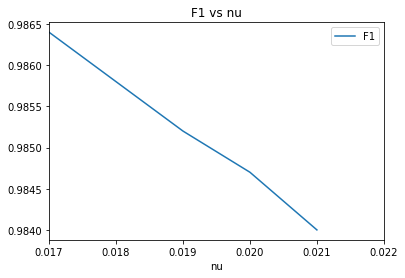

In [15]:
EpsF1df.plot.line("nu","F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs nu")
plt.show()

In [16]:
from sklearn.metrics import classification_report


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.21      1.00      0.35      2210
           1       1.00      0.97      0.98    265288

    accuracy                           0.97    267498
   macro avg       0.60      0.98      0.66    267498
weighted avg       0.99      0.97      0.98    267498

